#**Question-1:Neural Network**

---

**Download Mnist Dataset**

In [23]:
import torch
print(torch.__version__)

2.2.1+cu121


In [24]:
import torchvision
import torchvision.datasets as datasets

In [25]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=None, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=None, download=True)

In [26]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),  # Randomly rotate images by up to 10 degrees
    transforms.RandomCrop(size=28, padding=4),  # Randomly crop images to size 28x28 with padding of 4
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image data
])

##**Task-1:Data Loader**

In [27]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [28]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

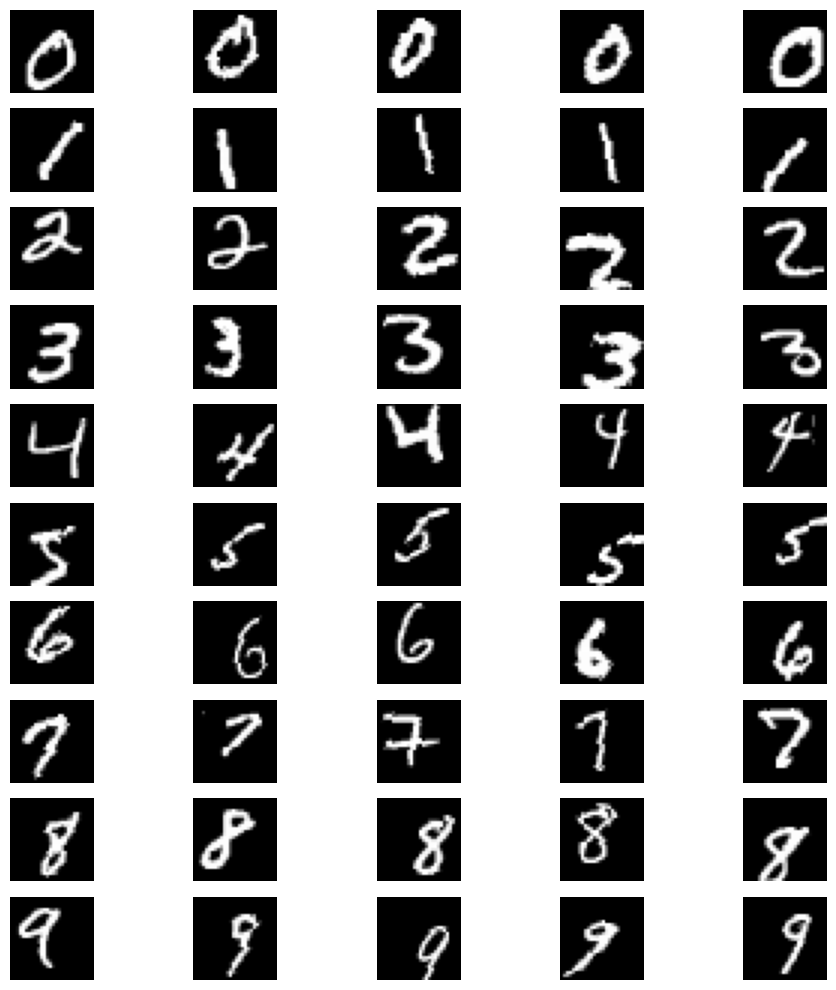

In [29]:
import matplotlib.pyplot as plt

def plot_images(dataset):
    class_indices = {}

    for i, (image, label) in enumerate(dataset):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)

    num_classes = len(class_indices)
    num_images_per_class = 5
    fig, axs = plt.subplots(num_classes, num_images_per_class, figsize=(10, 10))

    for i in range(num_classes):
        class_label = i
        for j in range(num_images_per_class):
            image_index = class_indices[class_label][j]
            image, _ = dataset[image_index]
            axs[i, j].imshow(image.squeeze(), cmap='gray')
            axs[i, j].axis('off')

    for ax, label in zip(axs[:, 0], range(num_classes)):
        ax.set_ylabel('Class {}'.format(label), rotation=90, size='large')

    plt.tight_layout()
    plt.show()

plot_images(train_dataset)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

class FNet(nn.Module):
    def __init__(self):
        super(FNet, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.out = nn.Linear(256, 10)

        self.dropout = nn.Dropout(0.2)# avoiding overfitting

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.out(x)
        return x

model = FNet()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", total_params)

Number of trainable parameters: 535818


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

model = FNet()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
best_accuracy = 0.0
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
for epoch in range(5):
    # Training
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0) # Accumulate the loss
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_train_loss / len(train_loader.dataset) # Calculate the mean loss
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    running_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_valid_loss += loss.item() * images.size(0) # Accumulate the loss
            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    valid_loss = running_valid_loss / len(test_loader.dataset) # Calculate the mean loss
    valid_accuracy = correct_valid / total_valid
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    # Save the best model
    if valid_accuracy > best_accuracy:
        best_accuracy = valid_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    print(f"Epoch {epoch+1}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")


Best model saved.
Epoch 1:
Train Loss: 0.9616, Train Accuracy: 0.6803
Validation Loss: 0.4301, Validation Accuracy: 0.8687
Best model saved.
Epoch 2:
Train Loss: 0.4997, Train Accuracy: 0.8399
Validation Loss: 0.3195, Validation Accuracy: 0.9015
Best model saved.
Epoch 3:
Train Loss: 0.4092, Train Accuracy: 0.8713
Validation Loss: 0.2814, Validation Accuracy: 0.9135
Best model saved.
Epoch 4:
Train Loss: 0.3715, Train Accuracy: 0.8828
Validation Loss: 0.2216, Validation Accuracy: 0.9307
Best model saved.
Epoch 5:
Train Loss: 0.3435, Train Accuracy: 0.8922
Validation Loss: 0.2051, Validation Accuracy: 0.9362


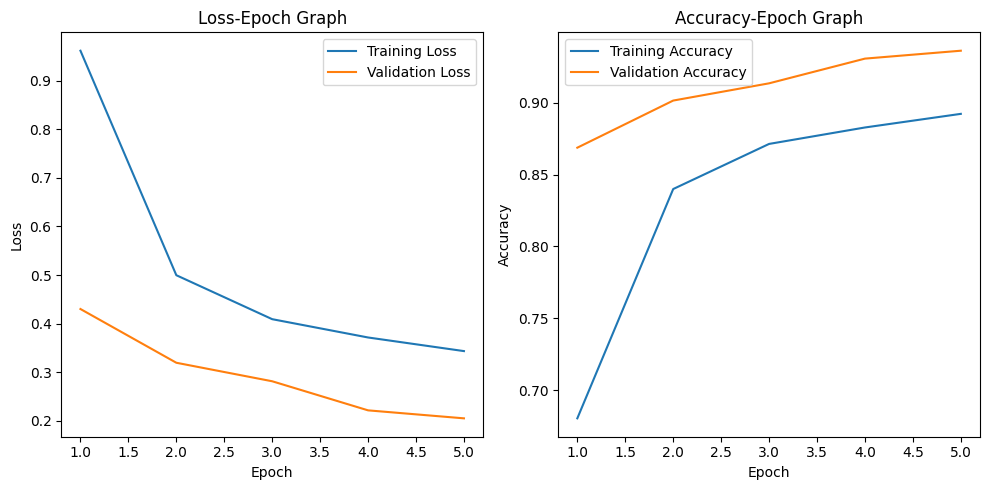

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss-Epoch Graph')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy-Epoch Graph')
plt.legend()

plt.tight_layout()
plt.show()
